In [11]:
import  scipy.signal.signaltools
%matplotlib notebook

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

import dtscalibration

import os
import warnings

warnings.simplefilter('ignore')  # Hide warnings to avoid clutter in the notebook

from dtscalibration import suggest_cable_shift_double_ended
from dtscalibration import read_silixa_files
from matplotlib import pyplot as plt
import numpy as np
from dtscalibration import shift_double_ended
import math

%matplotlib inline

3 files were found, each representing a single timestep
6 recorded vars were found: LAF, ST, AST, REV-ST, REV-AST, TMP
Recorded at 3553 points along the cable
The measurement is double ended
Reading the data from disk
I dont know what to do with the following data ['tmp']
I dont know what to do with the following data ['tmp']
I dont know what to do with the following data ['tmp']
<xarray.DataArray 'x' (x: 2471)>
array([1.33000e-01, 3.88000e-01, 6.42000e-01, ..., 6.27497e+02, 6.27751e+02,
       6.28006e+02])
Coordinates:
  * x        (x) float64 0.133 0.388 0.642 0.896 ... 627.2 627.5 627.8 628.0
Attributes:
    name:              distance
    description:       Length along fiber
    long_description:  Starting at connector of forward channel
    units:             m 


 <xarray.DataArray 'x' (x: 2469)>
array([1.33000e-01, 3.88000e-01, 6.42000e-01, ..., 6.26989e+02, 6.27243e+02,
       6.27497e+02])
Coordinates:
  * x        (x) float64 0.133 0.388 0.642 0.896 ... 626.7 627.0 627.2 62

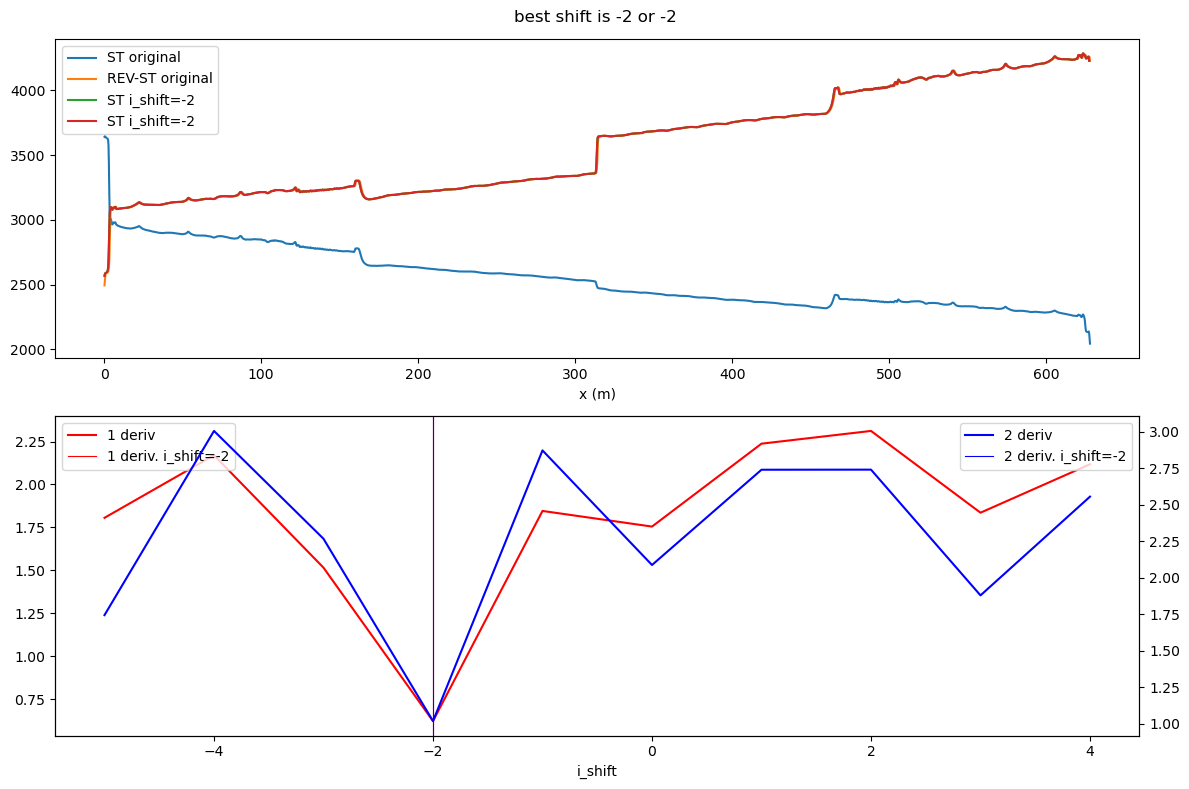

In [3]:
filepath = ''

ds_ = read_silixa_files(
    directory=filepath,
    timezone_netcdf='UTC',
    file_ext='*.xml')

ds = ds_.sel(x=slice(0, 628.2))  # only calibrate parts of the fiber


sections = {
    'probe1Temperature': [slice(130., 158.)],  # temp isolator
    }
ds.sections = sections

suggested_shift = suggest_cable_shift_double_ended(
    ds,
    np.arange(-5, 5),
    plot_result=True,
    figsize=(12,8))

ds_restored = shift_double_ended(ds, suggested_shift[0])

print(ds.x, 3*'\n', ds_restored.x)

matching_sections = [
    (slice(130., 158.), slice(470.5, 498.75), False)
]
sections = {
    'probe1Temperature': [slice(130., 158.), slice(470., 500.)]
    }
ds_.sections = sections
st_var, resid = ds.variance_stokes(st_label='st')
ast_var, _ = ds.variance_stokes(st_label='ast')
rst_var, _ = ds.variance_stokes(st_label='rst')
rast_var, _ = ds.variance_stokes(st_label='rast')

ds.calibration_double_ended(
    st_var=st_var,
    ast_var=ast_var,
    rst_var=rst_var,
    rast_var=rast_var,
    trans_att=[314.25],
    matching_sections=matching_sections,
    store_tmpw='tmpw',
    method='wls',
    solver='sparse')

ds_.calibration_double_ended(
    st_var=st_var,
    ast_var=ast_var,
    rst_var=rst_var,
    rast_var=rast_var,
    store_tmpw='tmpw',
    method='wls',
    solver='sparse')


# 0. DTS massaging

In [17]:
top_trend = 182 #optical distance (m), This is what we think the start of the long term signal is.
bottom_trend = 312.5 #optical distance (m), This is the bottom of the trend just above the warm bottom anomaly..
start_of_borehole = 162 #optical distance (m), Top of the borehole.

mean_sig1 = (ds.isel(time=0).tmpw + ds.isel(time=0).tmpw[::-1])/2
mean_sig2 = (ds.isel(time=1).tmpw + ds.isel(time=1).tmpw[::-1])/2
mean_sig3 = (ds.isel(time=2).tmpw + ds.isel(time=2).tmpw[::-1])/2

mean_tot = (mean_sig1 + mean_sig2 + mean_sig3) / 3

In [233]:
#Parameters

tmax = 2023
tmin = 1923
zmax = bottom_trend - top_trend#150
dTdz = 0.02
nz = len(mean_tot.sel(x=slice(top_trend,bottom_trend)))
nt = 99
alpha = 46
accumulation = 0

years = np.arange(tmin, tmax -1,1)

In [234]:
start_here = 0   # 0 is the start of the top of the trend

m,b = np.polyfit(mean_tot.sel(x=slice(top_trend+start_here,bottom_trend)).x, 
                 mean_tot.sel(x=slice(top_trend+start_here,bottom_trend)), 1)

Q_geo = m *2.5*1e3
print(Q_geo)
print(b)

x  = m*mean_tot.sel(x=slice(top_trend+start_here,bottom_trend)).x + b

y  = m*mean_tot.sel(x=slice(top_trend,bottom_trend)).x + b
anomaly = mean_tot.sel(x=slice(top_trend,bottom_trend)) - y

43.493828867493384
-33.53724531830064


# 1. G matrix is determined by the complimentary error functions.

See Beltrami 1992

In [235]:
z = mean_tot.sel(x=slice(top_trend,bottom_trend)).x.values - start_of_borehole
t = np.arange(0,nt+1,1)
k_diff = 1.09e-6 * 3.154e+7 ## * 3.154e7

# print(t)
# print(z)

In [281]:
A_jk = np.zeros(shape = (len(z), len(t)-1))

for k in range(len(t) - 1):
    for j in range(len(z)):
        #print(t[k])
        #A_jk[j,k] = (math.erfc(z[j] / (2*np.sqrt(k_diff * t[k])))) - (math.erfc(z[j] / (2*np.sqrt(k_diff * t[k+1]))))
        A_jk[j,k] = (math.erfc(z[j] / (2*np.sqrt((k_diff**2) * t[k])))) - (math.erfc(z[j] / (2*np.sqrt((k_diff**2) * t[k+1]))))

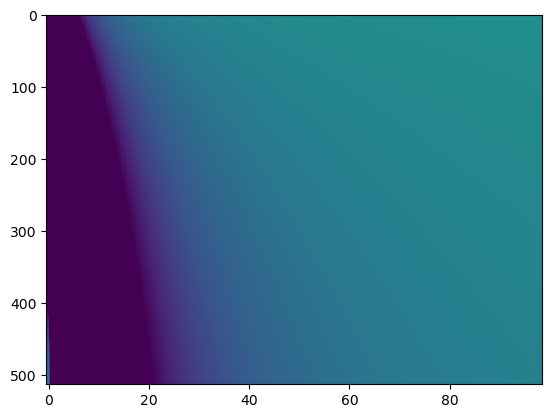

In [282]:
fig, ax = plt.subplots() 
ax.imshow(A_jk, aspect ='auto', vmin = -1e-2, vmax =1e-2)

# 2.0 Perform the SVD

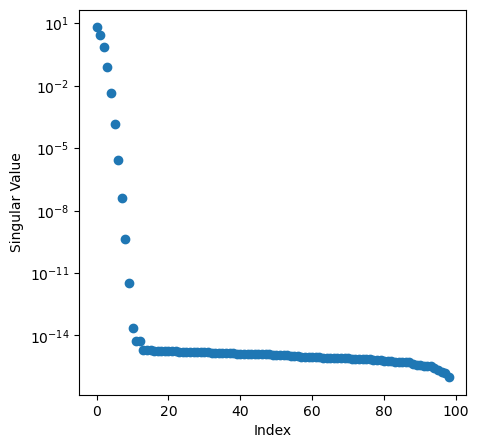

In [283]:
#Singular value decomposition
u, s, v_T = np.linalg.svd(A_jk, full_matrices=True)


#Plotting the singular values
fig,ax = plt.subplots(figsize=[5,5])
plt.scatter(np.arange(0,len(s)),s)
ax.set_xlabel('Index')
ax.set_ylabel('Singular Value')
ax.set_yscale('log')
#ax.set_xlim([0,10])
# print(s)
#fig.savefig('singular_values.eps')
plt.show()

### 2.1 Apply the thresholding

In [297]:
p = 4 #Applying the thresholding
u_p = u[:,:p]
s_p = np.diag(s[:p])
vh_p = v_T.T[:,:p]

# print('U_p =\n', u_p)
# print('S_p =\n',s_p)
# print('V_p =\n',vh_p)

### 2.2 Find the generalized G matrix and inverse G matrix

In [298]:
#Now finding the generalized G matrix

g_gen = u_p @ s_p @ vh_p.T
# print('G = \n', g_gen)

#And the inverse Gen G matrix

u_p_transpose = u_p.T
s_p_inv = np.linalg.inv(s_p)

g_inv = vh_p @ s_p_inv @ u_p_transpose

# print('G^-g = \n', g_inv)

# 3.0 Inversion and model estimates for past surface temperatures

Text(0.5, 0, 'Year')

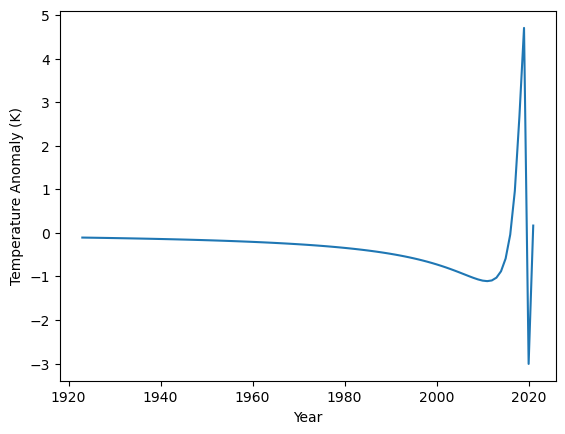

In [299]:
#model estimates

m_est = g_inv @ anomaly.values


fig,ax = plt.subplots()
ax.plot(years[::-1],m_est)
ax.set_ylabel('Temperature Anomaly (K)')
ax.set_xlabel('Year')

# 3.1 Data prediction from inversion

Text(0.5, 0, 'Depth')

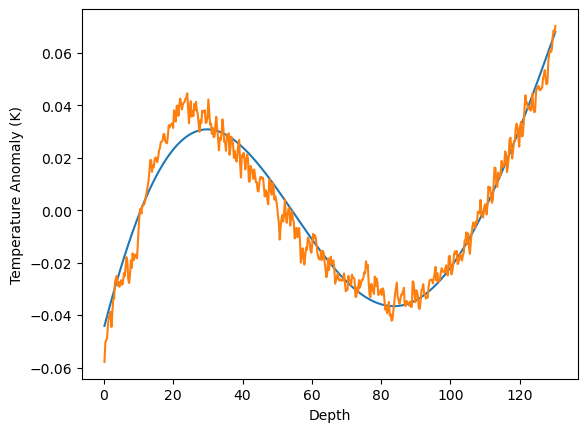

In [295]:
#Predicted data
d_predicted = A_jk @ m_est

fig,ax = plt.subplots()
ax.plot(z - 20,d_predicted, label='Predicted Data')
ax.plot(anomaly.x - top_trend, anomaly.values, label='Actual Data')
ax.set_ylabel('Temperature Anomaly (K)')
ax.set_xlabel('Depth')

# 4.0 Testing the thresholding

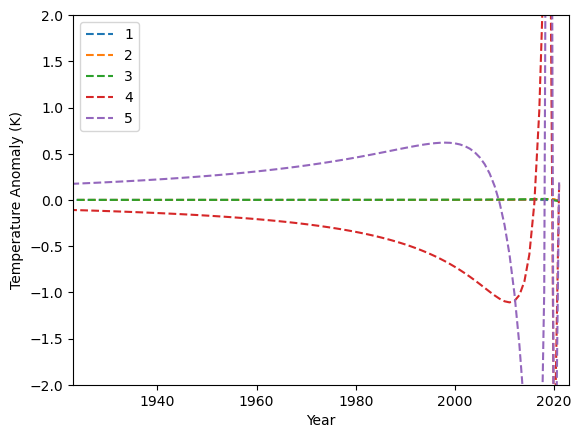

In [296]:
fig, ax = plt.subplots()

ax.set_ylabel('Temperature Anomaly (K)')
ax.set_xlabel('Year')
ax.set_ylim([-2,2])

for i in np.arange(1,6,1):
    
    p = i #Applying the thresholding
    u_p = u[:,:p]
    s_p = np.diag(s[:p])
    vh_p = v_T.T[:,:p]
    
    #Now finding the generalized G matrix

    g_gen = u_p @ s_p @ vh_p.T
    # print('G = \n', g_gen)

    #And the inverse Gen G matrix

    u_p_transpose = u_p.T
    s_p_inv = np.linalg.inv(s_p)

    g_inv = vh_p @ s_p_inv @ u_p_transpose

    # print('G^-g = \n', g_inv)
    
    m_est = g_inv @ anomaly.values
    
    ax.plot(years[::-1],m_est, ls='--', label = str(i))

ax.set_xlim([1923,2023])
plt.legend()

# 5.0 Maximum resolvable temperature

# 6.0 Monte Carlo smiulations with restarts

In [300]:
import copy
from tqdm import tqdm

# 1) guess m_i (we have a good guess right now, the first m_est we calculated). This will be the first iteration of the MC
m_est = g_inv @ anomaly.values

d_pred_i = A_jk @ m_est
d_obs = anomaly.values
#r_i = (1 / (np.sqrt(2*np.pi) * sigma)) * np.exp(-(sum((d_obs - d_pred_i[:-1])**2))**2 / 2*(sigma**2))
r_i = sum(np.abs(d_pred_i- d_obs))
m_accepted_all = [m_est]
m_not_accepted = []
predicted_data = []
r_values = [r_i]
sigma = 0.01 #st dev of temperature measurement

iterations = 500
restarts = 100
best_of_restart = []
for j in tqdm(range(restarts)):
    m_accepted = [m_est]
    for i in range(iterations):

        # 1) guess m_i (we have a good guess right now, the first m_est we calculated). This will be the first iteration of the MC

    #     m_i = m_est
    #     m_accepted = [m_i]
    #     d_pred_i = G_copy @ m_i
    #     d_obs = anomaly.values
        #r_i = (1 / (np.sqrt(2*np.pi) * sigma)) * np.exp(-(sum((d_obs - d_pred_i[:-1])**2))**2 / 2*(sigma**2))
    #     r_i = sum(np.abs(d_pred_i[:-1] - d_obs))

        #year_change = np.random.randint(0,m_i.shape[0]) #randomly select a year to change
    #     m_next = m_accepted[-1] #set the temp history as the most recent one to be accepted

        m_next_copy = copy.deepcopy(m_accepted[-1])
        change =  np.random.normal(loc=0,scale=.1, size = m_next_copy.shape) #change that year's temperature according to a random gaussian walk 

        m_next_copy = m_next_copy + change
        #Predicted data
        d_pred = A_jk @ m_next_copy

        # 2) r = (1 / (sqrt(2*pi) * sigma)) * exp(-(sum((d_obs - d_pred)**2))**2 / 2*(sigma**2) sigma = 0.01

        r = sum(np.abs(d_pred - d_obs))
        #print(r)
        sigma = 1 * np.sqrt(len(m_next_copy))
        #print(sigma)
        L = np.exp(-r**2/sigma**2 / 2) / np.sqrt(2*np.pi) / sigma 
        #print(L)
        #r = (1 / (np.sqrt(2*np.pi) * sigma)) * np.exp(-(sum((d_obs - d_pred[:-1])**2))**2 / 2*(sigma**2))
        #print('r = ' + str(r)+ ', and r_0 = ' + str(r_i))
        alpha = np.random.rand()
        #print(alpha)

        ### Do this to always improve ###

        if L > alpha:
            r_values.append(r)
            m_accepted_all.append(m_next_copy)
            predicted_data.append(d_pred)
            m_accepted.append(m_next_copy)
            #print('r = ' + str(r))
#             print('L = '+ str(L)+'  , alpha = '+str(alpha))
#             print("accepted")
        if L < alpha:
            m_not_accepted.append(m_next_copy)
    best_of_restart.append(np.asarray(m_accepted[-1]).T)
#     ### Do this to always to always keep performers that beat the SVD ###
    
#     if r < r_i:
#         r_values.append(r)
#         m_accepted.append(m_next_copy)
#         predicted_data.append(d_pred)
#         print('r = ' + str(r))
#     if r > r_i:
#         m_not_accepted.append(m_next_copy)

# fig, ax= plt.subplots()
# ax.plot(m_est)
# ax.plot(np.asarray(m_accepted).T)

# fig, ax= plt.subplots()
# ax.plot(m_est)
# ax.plot(np.asarray(m_not_accepted).T)

100%|██████████| 100/100 [00:06<00:00, 15.95it/s]


In [301]:
std_all = np.std(np.asarray(m_accepted_all).T, axis=1)
mean_all = np.mean(np.asarray(m_accepted_all).T, axis=1)

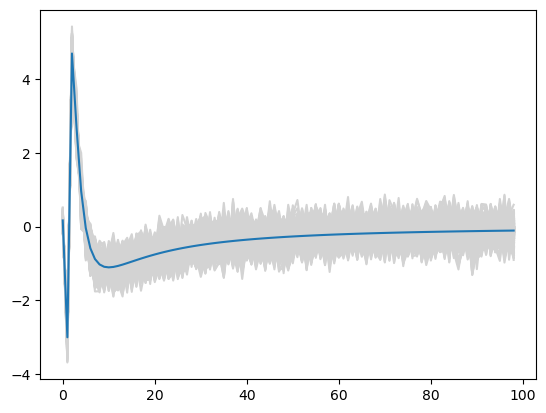

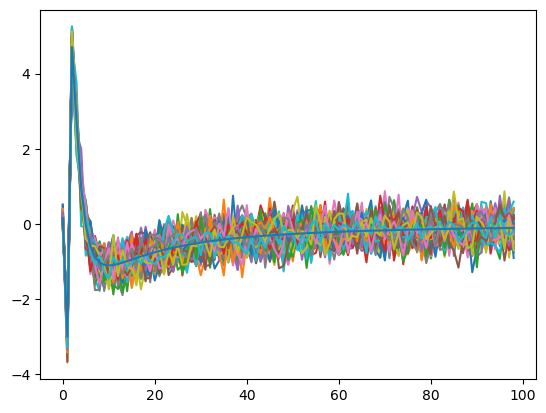

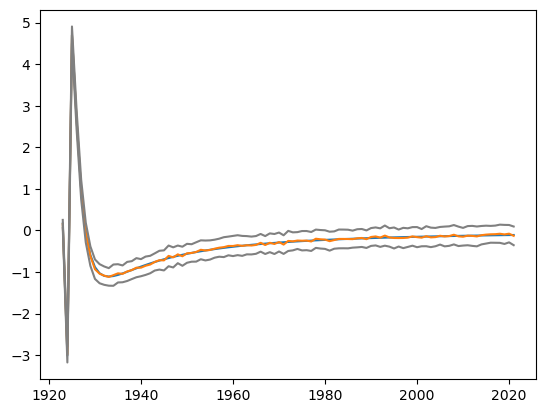

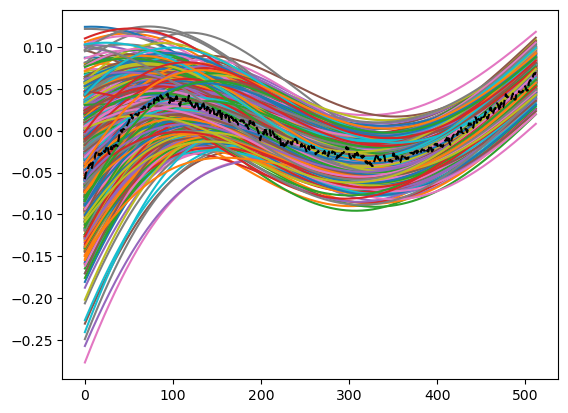

In [302]:
fig, ax= plt.subplots()

ax.plot(np.asarray(m_accepted_all).T, color='lightgrey')
ax.plot(m_est)

fig, ax= plt.subplots()
ax.plot(np.asarray(best_of_restart).T)
ax.plot(m_est)

fig, ax= plt.subplots()
ax.plot(years,m_est)
ax.plot(years,mean_all)
ax.plot(years,mean_all+std_all, color = 'grey')
ax.plot(years,mean_all-std_all, color = 'grey')

fig, ax= plt.subplots()
ax.plot(np.asarray(predicted_data).T)
ax.plot(d_obs, ls='--', c='black')
plt.show()

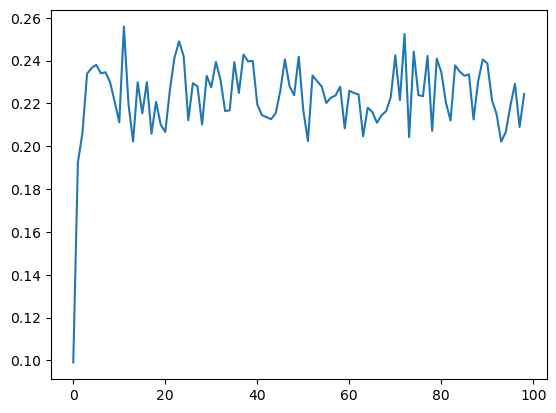

In [303]:
fig, ax= plt.subplots()
ax.plot(std_all)

plt.show()